# Ejemplo básico de uso de EVQueues

## Grupo MATE - Universidad ORT Uruguay

## La biblioteca`EVQueues.jl`

La biblioteca `EVQueues.jl` es una bilioteca que permite simular diferentes políticas de carga de vehículos eléctricos en un parque de carga.

Los componentes principales son:

* El objeto de tipo `EVSim`, que posee todas las salidas de una simulación.
* Las políticas, definidas en la biblioteca y que se pueden extender. Se definen por ejemplo EDF, LLF, LLR (del paper), FIFO, LIFO, Longest Remaining Processing Time (LRPT), entre otras.
* Los métodos `ev_xxx` y `ev_xxx_trace`, donde `xxx` es la política. El primero permite simular un proceso estacionario de carga, y el segundo a partir de una traza de arribos preconstruida.

Abajo damos un ejemplo de uso de `ev_edf` (las otras políticas son similares). Comenzamos cargando la biblioteca.

In [1]:
#En caso de ser necesario, para bajar los paquetes descomentar esta línea
#using Pkg; Pkg.instantiate()

using EVQueues, Plots

El método `ev_edf` recibe como parámetros:

 * La tasa $\lambda$ de arribo de vehículos (arribos Poisson, es decir cada tiempo exponencial).
 * La tasa $\mu$ de servicio. Esto es $1/\mu$ es la energía media requerida. Se asume potencia $1$ por vehículo por lo que también es el tiempo medio de servicio, supuesto exponencial.
 * La tasa $\gamma$ de laxity. Cada vehículo llega con un deadline extra de media $1/\gamma$. Es decir la estadía promedio es $1/\mu + 1/\gamma$ y todos los vehículos son a priori factibles.
 * La capacidad del parque, que es equivalente en este caso al no. de cargadores. Si no se pasa se asume infinita.
 * El tiempo de simulación `Tfinal`.
 * Un vector opcional de `snapshots` donde se guarda el estado del sistema en ese momento del tiempo.
 
 La carga del sistema es:
 $$\rho = \frac{\lambda}{\mu}$$
 y si es $\rho> C$ estará en overload.

In [2]:
lambda=120.0; #EVs por hora.
mu=1.0; #1/duración de carga en horas.
gamma=1.0; #1/duración del laxity en horas
C=60.0; #cantidad de cargadores.

Tfinal=100.0; #duración.

In [3]:
#Se realiza la simulación
sim = ev_edf(lambda,mu,gamma,Tfinal,C,snapshots=[Tfinal]);

Simulando... 100%|██████████████████████████████████████| Time: 0:00:02


Analicemos el objeto `sim`. Este posee:

 * Un diccionario donde se guardan los parámetros.
 * Una `timetrace` donde hay un vector $T$ de tiempos, $X$ de vehículos aún en carga e $Y$ de vehículos ya cargados. También un vector $P$ de potencia consumida.
 * Un array `EVs` donde se guardan los datos de cada vehículo completado.
 * Algunas estadísticas, que solo se llenan si se llama a `compute_statistics!(sim)`. Por ejemplo media de ocupación o energía no entregada.

In [5]:
compute_statistics!(sim)

In [6]:
println(sim.parameters)
print("Average unfinished work: $(sim.stats.avgW)")

Dict{String,Any}("ArrivalRate" => 120.0,"SnapshotTimes" => [100.0],"AvgEnergy" => 1.0,"Policy" => "EDF","AvgDeadline" => 2.0,"SimTime" => 100.0,"Capacity" => 60.0)
Average unfinished work: 0.4816539160060385

### Análisis de la evolución temporal

Para graficar la evolución temporal extraemos los datos de `sim.timetrace`. Aquí se crea el plot y luego se le agrega la traza deseada.

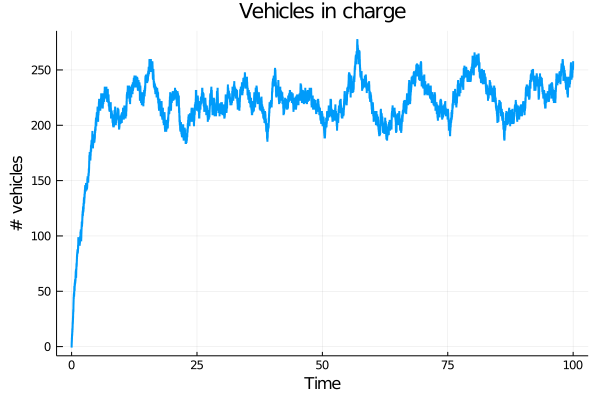

In [6]:
#TIme plot of occupation
p = plot(  xlabel="Time",
            ylabel="# vehicles",
            title="Vehicles in charge")

plot!(p, sim.timetrace.T, sim.timetrace.X,lt=:steppost,linewidth=2,legend=:none)

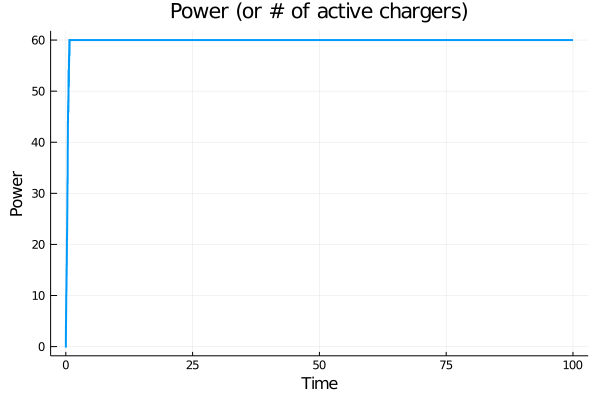

In [7]:
#TIme plot of power
p = plot(  xlabel="Time",
            ylabel="Power",
            title="Power (or # of active chargers)")

plot!(p, sim.timetrace.T, sim.timetrace.P,lt=:steppost,linewidth=2,legend=:none)

### Análisis del trabajo realizado, o métricas de cada vehículo

Si queremos ver cuánto trabajo se le entregó a cada vehículo, podemos chequear el vector `sim.EVs` que tiene todos los vehículos entregados (objetos de tipo `EVInstance`). En `departureWorkload` está la energía *que restaba por entregar* al irse.

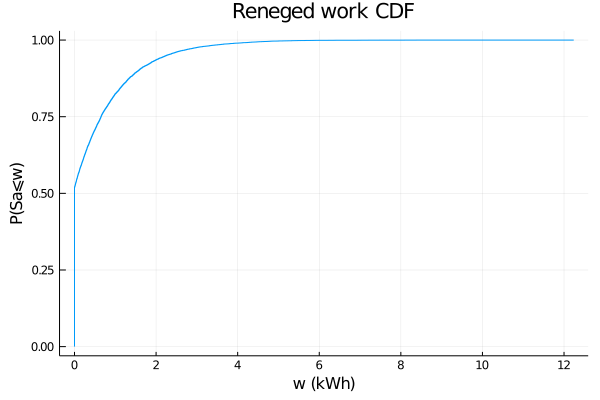

In [7]:
#CDF of departure attained workloads

#Recupero todos los workloads finales y los ordeno
Sa = sort([ev.departureWorkload for ev in sim.EVs]);
n = length(Sa);

#Grafico la distribución empírica acumulada
p = plot(   xlabel="w (kWh)",
            ylabel="P(Sa⩽w)",
            title="Reneged work CDF")

plot!(p,Sa,(1:n)/n,lt=:steppost,legend=:none)

### Visualización del espacio de estados.

Si queremos graficar el estado del sistema, tomamos un snapshot (por ejemplo el último, en este caso es el único y se tomó en `Tfinal`). El array `charging` tiene todos los vehículos que están en proceso de carga en ese momento.

Ahora graficamos a quiénes estábamos atendiendo en el momento del snapshot, y cuánto deadline y trabajo remanente tenían.

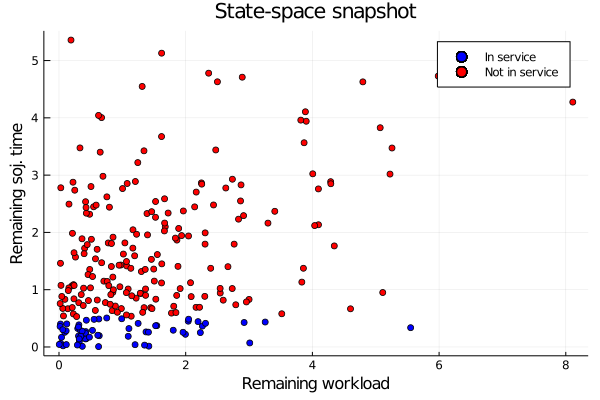

In [9]:
#State space of the last snapshot
snap = sim.snapshots[end];

w = [ev.currentWorkload for ev in snap.charging];
d = [ev.currentDeadline for ev in snap.charging];
on = [ev.currentPower>0 for ev in snap.charging];

p = plot(   xlabel = "Remaining workload",
            ylabel = "Remaining soj. time",
            title = "State-space snapshot")

scatter!(p,w[on.==true],d[on.==true],markershape=:circle,markersize=4,color=:blue,label="In service")
scatter!(p,w[on.==false],d[on.==false],markershape=:circle,markersize=4,color=:red,label="Not in service")

### Fairness (Jain Index)

Por último, la biblioteca posee un cálculo de justicia basada en el índice de Jain (ver paper). El método `compute_fairness` calcula la justicia en el reparto en la simulación en tiempo $t$ comparando los vehículos que finalizaron en las últimas $h$ unidades de tiempo.

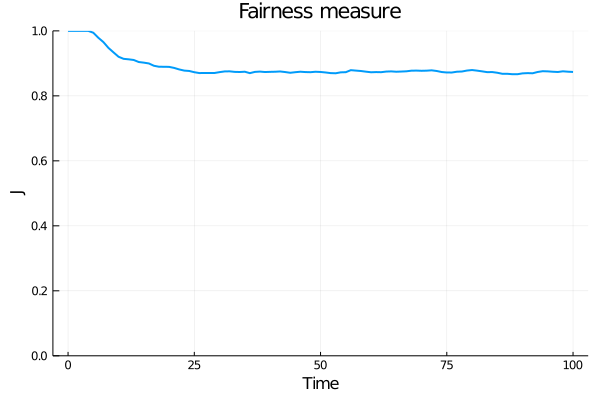

In [10]:
#fairness measure over time

t=collect(0:Tfinal);
h=20.0;
J=compute_fairness(sim,t,h)

p = plot(   xlabel = "Time",
            ylabel = "J",
            title = "Fairness measure",
            ylim = (0,1)
            )

plot!(p,t,J,lw=2,legend=:none)

In [4]:
sim

EVSim(Dict{String,Any}("ArrivalRate" => 120.0,"SnapshotTimes" => [100.0],"AvgEnergy" => 1.0,"Policy" => "EDF","AvgDeadline" => 2.0,"SimTime" => 100.0,"Capacity" => 60.0), EVQueues.TimeTrace([0.0, 0.008797503155212476, 0.03563677694562411, 0.04855969659683887, 0.055986782559984065, 0.07342496176407828, 0.0741688365375216, 0.07827406755377352, 0.08605898134685236, 0.0879178383220301  …  99.97623958202155, 99.97880528623058, 99.98116001315313, 99.98832453867816, 99.99195573623076, 99.99262798209335, 99.99294754225309, 99.99367797763658, 99.99650630010133, 100.00000000000095], UInt16[0x0000, 0x0001, 0x0002, 0x0003, 0x0004, 0x0005, 0x0006, 0x0007, 0x0008, 0x0009  …  0x00da, 0x00db, 0x00dc, 0x00db, 0x00da, 0x00db, 0x00da, 0x00d9, 0x00da, 0x00da], UInt16[0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000, 0x0000  …  0x0014, 0x0014, 0x0014, 0x0014, 0x0015, 0x0015, 0x0015, 0x0015, 0x0015, 0x0015], [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  60.0, 60.0, 60.0, 60.0, 